In [1]:
import pandas as pd
import numpy as np
import csv
np.random.seed(seed=6)
import random
from random import sample
import pickle
np.random.seed(0)

In [2]:
## impart countries, continents and regions data
# path = 'C:/Users/mmoud/OneDrive/Desktop/DeepFoodChain/Data/'
filename = 'countryContinent.csv'
countries = pd.read_csv(filename,encoding='gbk')
countries = countries[['country', 'continent', 'sub_region','code_2']]

## impart countries, continents and regions data
# path = 'C:/Users/mmoud/OneDrive/Desktop/DeepFoodChain/Data/'
filename = 'lat_lon.csv'
coord = pd.read_csv(filename)

countries = pd.merge(countries, coord[['code', 'latitude', 
                           'longitude']] , how='left', left_on='code_2', right_on = 'code').drop(['code',
                                                            'code_2'], axis =1)

### replace names for USA so it matches between tables
countries['country'] = countries['country'].replace({'United States of America': 'United States',
                                                    'Bolivia (Plurinational State of)': 'Bolivia',
                                                    'Venezuela (Bolivarian Republic of)':'Venezuela',
                                                    'Brunei Darussalam': 'Brunei',
                                                    "C魌e d'Ivoire": "Côte d'Ivoire",
                                                    'Congo': 'Rep. Congo',
                                                    'Iran (Islamic Republic of)': 'Iran',
                                                    "Lao People's Democratic Republic": 'Laos',
                                                    'Macedonia (the former Yugoslav Republic of)': 'Macedonia',
                                                    'Syrian Arab Republic': 'Syria',
                                                    'Swaziland': 'eSwatini',
                                                    'Tanzania, United Republic of': 'Tanzania',
                                                    "Korea (Democratic People's Republic of)": 'North Korea',
                                                    'Korea (Republic of)': 'South Korea',
                                                    'Viet Nam': 'VietNam',
                                                    'United Kingdom of Great Britain and Northern Ireland':'United Kingdom',
                                                    'Russian Federation':'Russia'
                                                    })

In [3]:
data = pd.read_csv('coffee_clean.csv')
data = data.drop('Unnamed: 0', axis=1)
data.head(3)

,ReporterName,PartnerName,Quantity,Year,Reporter Income Group,Partner Income Group,continent_reporting,sub_region_reporting,latitude_x,longitude_x,continent_partner,sub_region_partner,latitude_y,longitude_y
0,Slovenia,Kenya,5.795978e+05,1996,High income,Lower middle income,Europe,Southern Europe,46.151241,14.995463,Africa,Eastern Africa,-0.023559,37.906193
1,Italy,Germany,2.528272e+08,1996,High income,High income,Europe,Southern Europe,41.871940,12.567380,Europe,Western Europe,51.165691,10.451526
2,Estonia,Poland,2.934837e+06,1996,High income,High income,Europe,Northern Europe,58.595272,25.013607,Europe,Eastern Europe,51.919438,19.145136


In [4]:
data = data.dropna(subset=['Year'])


In [5]:
## Extract year 2019
dat_15 = data[(data['Year'] == 2019)]
print('num edges: ', dat_15[['ReporterName', 'PartnerName']].drop_duplicates().shape[0])
display(dat_15.head(3))
print(" ")
print(dat_15[['ReporterName', 'PartnerName']].drop_duplicates().describe())
print(' ')
print('Total number of nodes: ', len(set(list(dat_15['ReporterName'].unique()) + list(dat_15['PartnerName'].unique()))))


num edges:  5176


,ReporterName,PartnerName,Quantity,Year,Reporter Income Group,Partner Income Group,continent_reporting,sub_region_reporting,latitude_x,longitude_x,continent_partner,sub_region_partner,latitude_y,longitude_y
87291,United Arab Emirates,Finland,42.00,2019,High income,High income,Asia,Western Asia,23.424076,53.847818,Europe,Northern Europe,61.924110,25.748151
87292,Azerbaijan,Lithuania,992.50,2019,Upper middle income,High income,Asia,Western Asia,40.143105,47.576927,Europe,Northern Europe,55.169438,23.881275
87293,Angola,Portugal,22115773.09,2019,Lower middle income,High income,Africa,Middle Africa,-11.202692,17.873887,Europe,Southern Europe,39.399872,-8.224454


 
       ReporterName PartnerName
count          5176        5176
unique          142         178
top          Canada       Italy
freq            112         126
 
Total number of nodes:  182


In [6]:
## supplier with most customer
dat_15[['ReporterName', 
        'PartnerName']].groupby('PartnerName').count().sort_values(by='ReporterName', ascending=False) #.describe()

,ReporterName
PartnerName,
Italy,126
United States,113
United Kingdom,109
Germany,108
France,105
...,...
Maldives,1
Mauritania,1
Mongolia,1


In [7]:
## importer with most suppliers and add describe to get mean number of customers and standard dev.
dat_15[['ReporterName', 
        'PartnerName']].groupby('ReporterName').count().sort_values(by='PartnerName', ascending=False)#.describe()

,PartnerName
ReporterName,
Canada,112
France,107
Switzerland,99
Germany,97
United Kingdom,93
...,...
Albania,5
Laos,3
Aruba,3


In [8]:
def get_demand_supply(data, year, verbose = False):
    dat_ = data[data.Year == year]
    demand = dat_.groupby(['ReporterName','Year'], 
                          as_index= False)['Quantity'].sum()
    # rename columns 
    demand = demand.rename(columns={'ReporterName': 'Country',
                                    'Quantity':'Demand', 'continent_reporting':'Region' })
    
   
    if verbose:
        display(demand.head(10))
        print(demand.shape)
        print(demand.Year.describe())

    ## Calculate Supply by countries 
    supply = dat_.groupby(['PartnerName','Year'], as_index= False)['Quantity'].sum()
    supply = supply.rename(columns={'PartnerName': 'Country',
                                    'Quantity':'Supply', 'continent_reporting':'Region' })
    # set supply to negative values
    supply['Supply'] = 1*supply['Supply']
#     supply = supply.drop('continent_partner', axis=1)
    if verbose:
        display(supply.head(10))
    ## merge demand and supply
    dem_sup = pd.merge(demand[['Country','Demand','Year']],supply,
                how="outer",on=['Country','Year']).fillna(0)
    
    ## add lat_lon 
    dem_sup = pd.merge(dem_sup ,countries,
                how="inner",left_on=['Country'], right_on=['country']).drop(['country'], axis=1)
    return dem_sup

In [9]:
## get demand and supply for 2019
dem_sup = get_demand_supply(dat_15, 2019)
dem_sup

,Country,Demand,Year,Supply,continent,sub_region,latitude,longitude
0,Afghanistan,1.281586e+05,2019,6.600000e+01,Asia,Southern Asia,33.939110,67.709953
1,Albania,1.072156e+08,2019,7.112083e+05,Europe,Southern Europe,41.153332,20.168331
2,Angola,2.601070e+07,2019,2.275960e+07,Africa,Middle Africa,-11.202692,17.873887
3,Antigua and Barbuda,9.184288e+05,2019,2.383400e+04,Americas,Caribbean,17.060816,-61.796428
4,Argentina,7.712531e+08,2019,3.855129e+06,Americas,South America,-38.416097,-63.616672
...,...,...,...,...,...,...,...,...
177,Tonga,0.000000e+00,2019,2.114900e+04,Oceania,Polynesia,-21.178986,-175.198242
178,Trinidad and Tobago,0.000000e+00,2019,2.056492e+05,Americas,Caribbean,10.691803,-61.222503
179,Turkmenistan,0.000000e+00,2019,2.235000e+04,Asia,Central Asia,38.969719,59.556278
180,Vanuatu,0.000000e+00,2019,3.523545e+05,Oceania,Melanesia,-15.376706,166.959158


In [10]:
dem_sup.describe()

,Demand,Year,Supply,latitude,longitude
count,1.820000e+02,182.0,1.820000e+02,182.000000,182.000000
mean,7.546145e+08,2019.0,7.546145e+08,18.558174,17.386907
std,3.041732e+09,0.0,3.186316e+09,24.855265,68.324032
min,0.000000e+00,2019.0,0.000000e+00,-40.900557,-175.198242
25%,3.783879e+05,2019.0,8.111337e+04,1.830694,-8.239031
50%,9.075973e+06,2019.0,7.419193e+06,17.858685,19.933678
75%,3.039190e+08,2019.0,1.426478e+08,39.901792,48.281523
max,3.107486e+10,2019.0,3.674987e+10,64.963051,179.414413


In [11]:
## get number of average demand and standard dev
(100* dem_sup.Demand/sum(dem_sup.Demand)).describe()

count    182.000000
mean       0.549451
std        2.214748
min        0.000000
25%        0.000276
50%        0.006608
75%        0.221290
max       22.626255
Name: Demand, dtype: float64

In [12]:
## extract max and average supply accross years
current_year =2019
df1 = get_demand_supply(data, current_year -10)

for ii in range(9):
    year = current_year-9+ii
#     print(year)
    df2 = get_demand_supply(data,year)
    df1 = pd.concat([df1, df2])
df1

,Country,Demand,Year,Supply,continent,sub_region,latitude,longitude
0,Albania,1.143187e+08,2009,8.393895e+05,Europe,Southern Europe,41.153332,20.168331
1,Algeria,1.913728e+09,2009,3.981400e+04,Africa,Northern Africa,28.033886,1.659626
2,Andorra,9.318523e+06,2009,3.584000e+04,Europe,Southern Europe,42.546245,1.601554
3,Angola,2.602584e+07,2009,2.154662e+07,Africa,Middle Africa,-11.202692,17.873887
4,Antigua and Barbuda,9.373227e+05,2009,3.893320e+05,Americas,Caribbean,17.060816,-61.796428
...,...,...,...,...,...,...,...,...
182,Trinidad and Tobago,0.000000e+00,2018,3.293992e+05,Americas,Caribbean,10.691803,-61.222503
183,Turkmenistan,0.000000e+00,2018,2.138000e+04,Asia,Central Asia,38.969719,59.556278
184,Vanuatu,0.000000e+00,2018,3.634666e+05,Oceania,Melanesia,-15.376706,166.959158
185,Venezuela,0.000000e+00,2018,1.118731e+08,Americas,South America,6.423750,-66.589730


In [23]:
max_sup = df1.groupby(['Country'], as_index=False).max()[['Country','Supply']]
max_sup = max_sup.rename(columns={"Supply": "max_sup"})
avg_sup = df1.groupby(['Country'], as_index=False).mean()[['Country','Supply']]
avg_sup =avg_sup.rename(columns={"Supply": "avg_sup"})
sup_std = df1.groupby(['Country'], as_index=False).std()[['Country','Supply']]
sup_std =sup_std.rename(columns={"Supply": "sup_std"})

In [22]:
#  df1.groupby(['Country'], as_index=False).count()[['Country','Supply']]

,Country,Supply
0,Afghanistan,1.042938e+03
1,Albania,1.233491e+05
2,Algeria,1.366281e+05
3,American Samoa,1.505261e+04
4,Andorra,3.910057e+04
...,...,...
195,Western Sahara,9.218207e+03
196,Yemen,1.013565e+06
197,Zambia,5.663440e+06
198,Zimbabwe,1.210555e+07


In [14]:
temp = df1[['Country','Supply']].copy()
temp.groupby('Country')['Supply'].apply(list)

Country
Afghanistan       [3271.0, 195.0, 651.0, 13.0, 656.0, 97.0, 95.0...
Albania           [839389.4720000001, 749085.0, 815949.0, 785201...
Algeria           [39814.0, 40838.0, 34031.0, 360256.836, 34861....
American Samoa        [507.0, 509.0, 4980.0, 375.0, 375.0, 37951.0]
Andorra           [35840.0, 6455.0, 35764.0, 2.0, 660.39, 33223....
                                        ...                        
Western Sahara                       [18675.0, 298.0, 298.0, 122.0]
Yemen             [107259601.26, 109472809.48200001, 108251383.1...
Zambia            [59149554.485, 61274758.04800001, 45868414.684...
Zimbabwe          [69851767.364, 65706304.834, 56587885.973, 572...
eSwatini          [191000.0, 211020.41, 35181.41, 13190.41, 8391...
Name: Supply, Length: 200, dtype: object

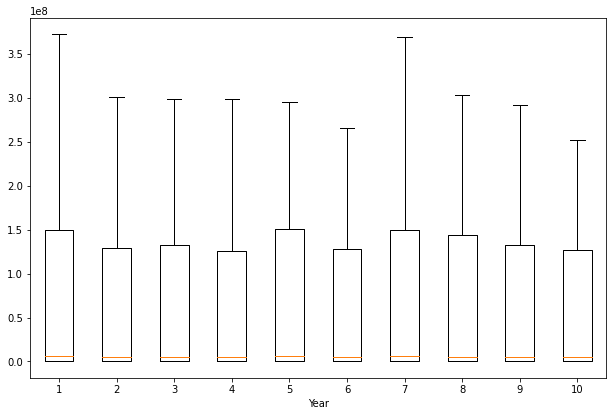

In [15]:
import matplotlib.pyplot as plt

temp = df1[['Year','Supply']].copy()
sups = temp.groupby('Year')['Supply'].apply(list)
supplies = []
countries = []
for country in list(sups.index): 
    countries.append(country)
    supplies.append(sups[country])
supplies

## plot box plot
slist =[]
for i in range(len(supplies)):
#     print(supplies[i])
    slist.append(supplies[i])

fig = plt.figure(figsize =(8, 5))
  
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
  
# Creating plot
bp = ax.boxplot(slist,showfliers=False)

plt.xlabel('Year')
# plt.ylabel('Scenario solutions')
# plt.title('Evolution of the Neutral risk model as scenarios increase')
  
# show plot
plt.show()  

In [26]:
# dem_sup
dem_sup_ = dem_sup.merge(max_sup, how='inner', on='Country')
dem_sup_ = dem_sup_.merge(avg_sup, how='inner', on='Country')
dem_sup_ = dem_sup_.merge(sup_std, how='inner', on='Country')
dem_sup_ = dem_sup_.sort_values(by=['avg_sup'], ascending=False)

dem_sup_

,Country,Demand,Year,Supply,continent,sub_region,latitude,longitude,max_sup,avg_sup,sup_std
20,Brazil,4.467111e+07,2019,3.674987e+10,Americas,South America,-14.235004,-51.925280,3.710701e+10,3.673507e+10,3.653772e+08
29,Colombia,5.338569e+08,2019,1.558990e+10,Americas,South America,4.570868,-74.297333,1.590833e+10,1.578218e+10,3.166728e+08
58,Indonesia,1.048104e+08,2019,9.272609e+09,Asia,South-Eastern Asia,-0.789275,113.921327,9.615210e+09,9.529765e+09,1.173979e+08
48,Germany,2.125049e+10,2019,6.966626e+09,Europe,Western Europe,51.165691,10.451526,7.105657e+09,7.039434e+09,6.468673e+07
52,Guatemala,3.913329e+06,2019,5.847327e+09,Americas,Central America,15.783471,-90.230759,5.859171e+09,5.809027e+09,1.434177e+08
...,...,...,...,...,...,...,...,...,...,...,...
6,Aruba,2.600863e+06,2019,1.000000e+00,Americas,Caribbean,12.521110,-69.968338,1.138862e+03,3.815586e+02,5.258107e+02
172,Solomon Islands,0.000000e+00,2019,1.680000e+03,Oceania,Melanesia,-9.645710,160.156194,1.680000e+03,3.494000e+02,5.884247e+02
137,Uzbekistan,7.479366e+05,2019,3.170000e+02,Asia,Central Asia,41.377491,64.585262,1.000000e+03,3.282500e+02,4.712935e+02
176,Tokelau,0.000000e+00,2019,1.300000e+01,Oceania,Polynesia,-8.967363,-171.855881,3.000000e+01,2.150000e+01,1.202082e+01


In [22]:
# import numpy as np 
# import matplotlib.pyplot as plt 
# plt.rcParams.update({'font.size': 11})
  
# X = dem_sup_.head(4)['Country'].copy()
# avg = dem_sup_.head(4)['avg_sup'].copy()
# actual = dem_sup_.head(4)['Supply'].copy()
  
# X_axis = np.arange(len(X))

# plt.figure(figsize=(16,6))
  
# plt.bar(X_axis - 0.2, avg, 0.4, label = 'Avg supply')
# plt.bar(X_axis + 0.2, actual, 0.4, label = '2019 supply')
# plt.xticks(X_axis, X)
# X = dem_sup_.tail(8)['Country'].copy()
# avg = dem_sup_.tail(8)['avg_sup'].copy()
# actual = dem_sup_.tail(8)['Supply'].copy()
  
# X_axis = np.arange(len(X))

# # plt.figure(figsize=(17,6))
  
# plt.bar(X_axis - 0.2, avg, 0.4, label = 'Avg supply')
# plt.bar(X_axis + 0.2, actual, 0.4, label = '2019 supply')
  
# plt.xticks(X_axis, X)
# plt.xlabel("Top four and bottom 4 ")
# plt.ylabel("Kg")
# # plt.title("Number of Students in each group")
# plt.legend()
# plt.show()

In [39]:
## mean deviation of avg values from actual values
np.mean(abs(dem_sup_.head(50)['avg_sup'].copy() - dem_sup_.head(50)['Supply'].copy())/dem_sup_.head(50)['avg_sup'].copy())

## mean deviation of avg values from actual values
np.mean(abs(dem_sup_.tail(30)['avg_sup'].copy() - dem_sup_.tail(30)['Supply'].copy())/dem_sup_.tail(30)['avg_sup'].copy())



0.04217564610845047

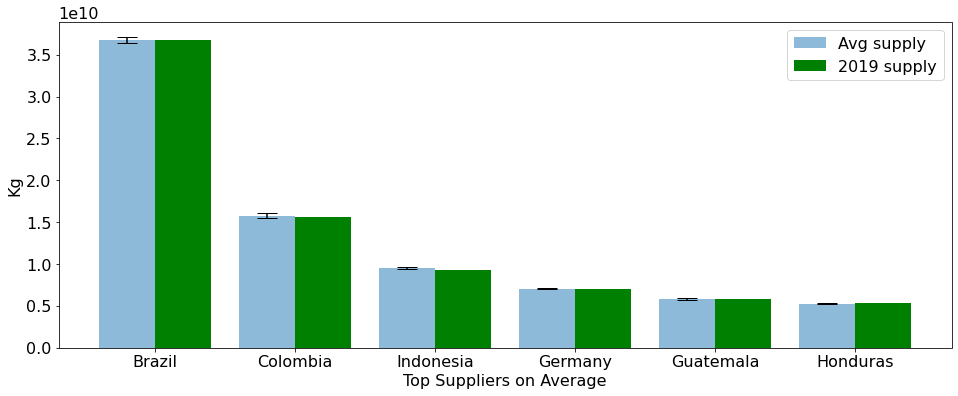

<Figure size 432x288 with 0 Axes>

In [28]:

import numpy as np 
import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 16})

# Build the plot
# fig, ax = plt.subplots()
  
X = dem_sup_.head(6)['Country'].copy()
avg = dem_sup_.head(6)['avg_sup'].copy()
actual = dem_sup_.head(6)['Supply'].copy()
error =   dem_sup_.head(6)['sup_std'].copy() 
X_axis = np.arange(len(X))

plt.figure(figsize=(16,6))
  
plt.bar(X_axis - 0.2, avg, 0.4,yerr=error, label = 'Avg supply', align='center', alpha=0.5, ecolor='black', capsize=10)
plt.bar(X_axis + 0.2, actual, 0.4, label = '2019 supply', color = 'green')
  
plt.xticks(X_axis, X)
plt.xlabel("Top Suppliers on Average")
plt.ylabel("Kg")
# plt.title("Number of Students in each group")
plt.legend()
plt.show()


# ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
# ax.set_ylabel('Coefficient of Thermal Expansion ($\degree C^{-1}$)')
# ax.set_xticks(x_pos)
# ax.set_xticklabels(materials)
# ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
# ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
# plt.savefig('bar_plot_with_error_bars.png')
# plt.show()

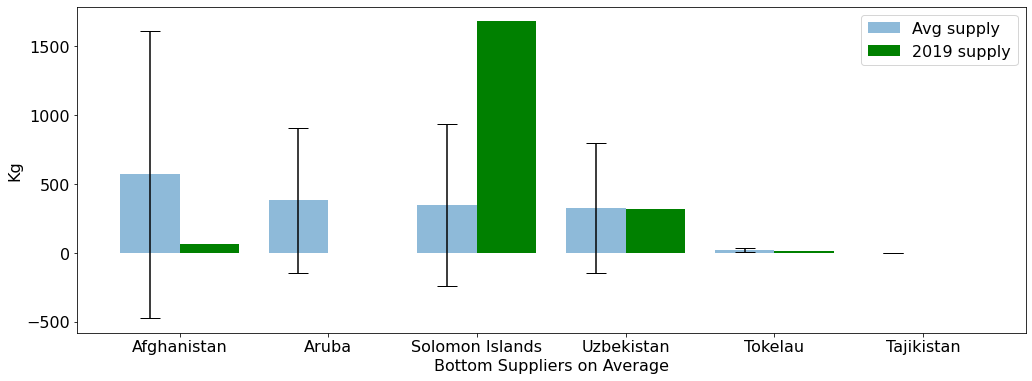

In [30]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = dem_sup_.tail(6)['Country'].copy()
avg = dem_sup_.tail(6)['avg_sup'].copy()
actual = dem_sup_.tail(6)['Supply'].copy()
error =   dem_sup_.tail(6)['sup_std'].copy() 
  
X_axis = np.arange(len(X))

plt.figure(figsize=(17,6))
  
# plt.bar(X_axis - 0.2, avg, 0.4, label = 'Avg supply')
plt.bar(X_axis - 0.2, avg, 0.4,yerr=error, label = 'Avg supply', align='center', alpha=0.5, ecolor='black', capsize=10)
plt.bar(X_axis + 0.2, actual, 0.4, label = '2019 supply',color ='green')
  
plt.xticks(X_axis, X)
plt.xlabel("Bottom Suppliers on Average")
plt.ylabel("Kg")
# plt.title("Number of Students in each group")
plt.legend()
plt.show()

In [15]:
display(dem_sup_.Supply.describe())
# ## number of countries in upper quartile of supply
print('Number of Suppliers in top quartile by volume')
print(sum(dem_sup_.Supply> 1.426478e+08))
print('Number of Suppliers in above mean by volume')
print(sum(dem_sup_.Supply> 7.419193e+06))

count    1.820000e+02
mean     7.546145e+08
std      3.186316e+09
min      0.000000e+00
25%      8.111337e+04
50%      7.419193e+06
75%      1.426478e+08
max      3.674987e+10
Name: Supply, dtype: float64

Number of Suppliers in top quartile by volume
46
Number of Suppliers in above mean by volume
91


In [16]:
## normalize the demand and supply values
from sklearn import preprocessing
df = dem_sup_.copy()

## re

x = df[['Demand','Supply', "max_sup", "avg_sup"]].values #.to_numpy() #returns a numpy array

# x.shape
# reshape data and fee to scaler so that values are relative to one another
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled= min_max_scaler.fit_transform(x.reshape(-1,1))
x_scaled = x_scaled.reshape(182,4)

## add scaled values
df.Demand = x_scaled[:,0]
df.Supply = x_scaled[:,1]
df.max_sup = x_scaled[:,2]
df.avg_sup = x_scaled[:,3]
df = df.fillna(0)
df['index'] = [i for i in range(1,len(df)+1)]
df

,Country,Demand,Year,Supply,continent,sub_region,latitude,longitude,max_sup,avg_sup,index
20,Brazil,0.001204,2019,9.903753e-01,Americas,South America,-14.235004,-51.925280,1.000000e+00,9.899767e-01,1
29,Colombia,0.014387,2019,4.201334e-01,Americas,South America,4.570868,-74.297333,4.287151e-01,4.253154e-01,2
58,Indonesia,0.002825,2019,2.498883e-01,Asia,South-Eastern Asia,-0.789275,113.921327,2.591211e-01,2.568185e-01,3
48,Germany,0.572681,2019,1.877442e-01,Europe,Western Europe,51.165691,10.451526,1.914910e-01,1.897063e-01,4
52,Guatemala,0.000105,2019,1.575801e-01,Americas,Central America,15.783471,-90.230759,1.578993e-01,1.565480e-01,5
...,...,...,...,...,...,...,...,...,...,...,...
6,Aruba,0.000070,2019,2.694909e-11,Americas,Caribbean,12.521110,-69.968338,3.069129e-08,1.028266e-08,178
172,Solomon Islands,0.000000,2019,4.527447e-08,Oceania,Melanesia,-9.645710,160.156194,4.527447e-08,9.416011e-09,179
137,Uzbekistan,0.000020,2019,8.542860e-09,Asia,Central Asia,41.377491,64.585262,2.694909e-08,8.846038e-09,180
176,Tokelau,0.000000,2019,3.503381e-10,Oceania,Polynesia,-8.967363,-171.855881,8.084726e-10,5.794054e-10,181


In [17]:
## create nodes csv
nodes = df[['Country','sub_region','Demand','Supply', "max_sup", "avg_sup"]].copy()
nodes.to_csv('../nodes.csv')
nodes.to_csv('../Deterministic/nodes.csv')


In [18]:
df_c = df[['Country','sub_region']].copy()
names_ = df_c['Country'].copy()

In [19]:
## demand data
# demand = pd.read_csv('dem_15.csv')
dem = df[['index', 'Demand']]
dem = dem.to_numpy()

# ## supply data
# supply = pd.read_csv('sup_15.csv')
sup =  df[['index', 'Supply']]
sup = sup.to_numpy()

# ## max supply data
# supply = pd.read_csv('sup_15.csv')
max_sup =  df[['index', 'max_sup']]
max_sup = max_sup.to_numpy()

# ## max supply data
avg_sup =  df[['index', 'avg_sup']]
avg_sup = avg_sup.to_numpy()



In [20]:
df[['index', 'Demand','Country']]

,index,Demand,Country
20,1,0.001204,Brazil
29,2,0.014387,Colombia
58,3,0.002825,Indonesia
48,4,0.572681,Germany
52,5,0.000105,Guatemala
...,...,...,...
6,178,0.000070,Aruba
172,179,0.000000,Solomon Islands
137,180,0.000020,Uzbekistan
176,181,0.000000,Tokelau


In [21]:
len(df_c)
df_c

,Country,sub_region
20,Brazil,South America
29,Colombia,South America
58,Indonesia,South-Eastern Asia
48,Germany,Western Europe
52,Guatemala,Central America
...,...,...
6,Aruba,Caribbean
172,Solomon Islands,Melanesia
137,Uzbekistan,Central Asia
176,Tokelau,Polynesia


## Creating scenarios sets

### At most 1 region with full capacity disruption

In [22]:
##  create Full capacity disruption in all scenarios
def full_dff(df_c):
    ''' 
    creating full matrix of scenarios with at least 2 disruption
    '''
    size = len(df_c)
    full_1 = np.ones((size,size)) - np.eye(size)
    ## create final scenarios dataframe 
    dff = pd.DataFrame(full_1)
    dff.loc[len(df_c)] = np.ones(size)
    return dff


##  create disruption in  subset of scenarios
def sub_dff(df_c, ix_list,verbose=False):
    ''' 
    creating full matrix of scenarios with at least 2 disruption
    '''
    size = len(df_c)
    full_1 = np.ones((size,size)) - np.eye(size)
    ## create final scenarios dataframe 
    dff = pd.DataFrame(full_1)
    dff.loc[len(df_c)] = np.ones(size)
    if verbose:
        print(dff.head())
        print('dff shape: ', dff.shape)
    dff_sub = dff[ix_list]
    return dff_sub


# dff.shape

In [23]:
def create_dat(dff,filename,dem,sup,df_c, gamma=0.75,zeta=0.1):
    '''
    inputs:
    (1)dataframe dff, ii by jj matrix with scenarios,
    (2) dem, sup: numpy arrays of demand and supply
    (3) file path and  name of the created file
    
    returns: creates a dat file in the new specified file path which is input for
    optimization model
    
    '''
    list_i  = [i for i in range(1,dff.shape[0])]
    list_s  = [i for i in range(0,dff.shape[1])]
    I = str(list_i)[1:-1].replace(',','')
    J = '0 ' + I 
    S = str(list_s)[1:-1].replace(',','')
    N = len(df_c)
    pi = 10
    gamma = gamma
    zeta =zeta
    
    file = open(filename,'w')
    ## create sets
    file.write('set I:= '+ I +';\n')
    file.write('set J:= '+ J +';\n')
    file.write('set S:= '+ S +';\n')
    ## number of nodes and penalty values
    file.write('\n')
    file.write('param N:= '+str(N)+';\n')
    file.write('param pi:= '+str(pi)+';\n')
    file.write('param gamma:= '+str(gamma)+';\n')
    file.write('param zeta:= '+str(zeta)+';\n')

    # create prob
    file.write('\n')
    file.write('param prob:=\n')
    for i in range(dff.shape[1]):
        Di = 1/dff.shape[1]
        file.write(str(i) + ' ' + str(Di)+'\n')
    file.write(';'+'\n')

    # create demand 
    file.write('\n')
    file.write('param D:=\n')
    for i in range(N):
        Di = str(int(dem[i][0]))+' '+ str(dem[i][1].round(3))
        file.write(Di+'\n')
    file.write(';'+'\n')

    # create supply
    file.write('\n')
    file.write('param P:=\n')
    file.write(str(0) + ' ' + str(1)+'\n')
    for i in range(N):
        Di = str(int(sup[i][0]))+' '+ str(sup[i][1].round(3))
        file.write(Di+'\n')
    file.write(';'+'\n')
    
    # create avg_supply
    file.write('\n')
    file.write('param G:=\n')
    file.write(str(0) + ' ' + str(1)+'\n')
    for i in range(N):
        Di = str(int(avg_sup[i][0]))+' '+ str(avg_sup[i][1].round(3))
        file.write(Di+'\n')
    file.write(';'+'\n')
    
    # create scenarios, 
    file.write('\n')
    file.write('param betas:'+ S + ':=\n')
    for i in range(dff.shape[0]):
        S = str(i)+' '+str(dff[i:i+1].values[0])[1:-1].replace('\n',"")
        file.write(S+'\n')
    file.write(';'+'\n')

In [24]:
ix_list = [3]
# print(df.head())
sub_dff(df_c, ix_list).head()

,3
0,1.0
1,1.0
2,1.0
3,0.0
4,1.0


## More functions for creating scenarios dataframnes: deprecated.

In [25]:
## create dff for randomly selecting scenarios
def create_df_t(index,df):
    size = len(df)
    a = np.ones((size,size)) - np.eye(size)
    full_1 = np.vstack((np.ones(size),a))

    ## randomly select scenario
    scenario = full_1[:,index]
    dff = pd.DataFrame(scenario)
    return dff



def create_df(index,df,scen_idx):
    ## Full capacity disruption
    jj = len(df)
    ss = len(scen_idx)
    full_1 = np.ones((jj+1,jj))
    s=0
    for j in range(1,jj) :
        if j in scen_idx.index.values:
    #         print(j)
            full_1[j,s] = 0
            s+=1

    ## create final scenarios dataframe 
    full_1 = full_1[:,:ss] 
    
    ## randomly select scenario
    scenario = full_1[:,index]
    print(scenario)
    dff = pd.DataFrame(scenario)
    return dff

# ## create subset of scenarios (5,10,20,50)
# def create_df_sc(index,df,scen_idx):
# #     size = len(df_c)
# #     full_1 = np.ones((size,size)) - np.eye(size)
    
#     ## Full capacity disruption
#     jj = len(df)
#     ss = len(scen_idx)
#     full_1 = np.ones((jj+1,jj))
# #     print(full_1)
#     s=0
#     print(scen_idx.index.values)
#     for j in range(1,jj) :
#         if j in scen_idx.index.values:
# #             print('j:',j)
#             full_1[j,s] = 0
#             s+=1

# #     ## create final scenarios dataframe 
# #     full_1 = full_1[:,:ss] 
    
#     ## randomly select scenario
#     scenario = full_1[:,index]
#     print(scenario)
#     dff = pd.DataFrame(scenario)
#     return dff




In [26]:

## update dictionary with key for Country names and corresponding index
name_dict = {}
for ii in df.index.values:
#     print(ii,df['index'][ii],df.Country[ii])
    name_dict[df['index'][ii]] = df.Country[ii]
pickle.dump(name_dict , open( "../stochastic/scens_two_stage/country_index_key.p", "wb" ) ) 

In [27]:
name_dict 
# df

{1: 'Brazil',
 2: 'Colombia',
 3: 'Indonesia',
 4: 'Germany',
 5: 'Guatemala',
 6: 'Honduras',
 7: 'Peru',
 8: 'India',
 9: 'Italy',
 10: 'Ethiopia',
 11: 'Uganda',
 12: 'Mexico',
 13: 'Belgium',
 14: 'Costa Rica',
 15: "Côte d'Ivoire",
 16: 'Nicaragua',
 17: 'El Salvador',
 18: 'United States',
 19: 'Papua New Guinea',
 20: 'Kenya',
 21: 'Netherlands',
 22: 'Switzerland',
 23: 'Tanzania',
 24: 'Cameroon',
 25: 'France',
 26: 'Poland',
 27: 'Canada',
 28: 'Spain',
 29: 'China',
 30: 'Slovenia',
 31: 'Austria',
 32: 'Ecuador',
 33: 'Sweden',
 34: 'United Kingdom',
 35: 'Burundi',
 36: 'Rwanda',
 37: 'Thailand',
 38: 'Laos',
 39: 'Togo',
 40: 'Guinea',
 41: 'Czech Republic',
 42: 'Portugal',
 43: 'Madagascar',
 44: 'Finland',
 45: 'Denmark',
 46: 'Dominican Republic',
 47: 'Panama',
 48: 'Bulgaria',
 49: 'Rep. Congo',
 50: 'Ireland',
 51: 'Malaysia',
 52: 'South Africa',
 53: 'Yemen',
 54: 'Bolivia',
 55: 'Hungary',
 56: 'Slovakia',
 57: 'Russia',
 58: 'Singapore',
 59: 'Luxembourg',
 60

In [28]:
## for single deterministic scenario case for all 182 countries
for s in range(1, len(df_c)+1):
    ## create and save scenario files in deterministic folder
    dff = create_df_t(s-1,df_c)
    filename = '../stochastic/scens_two_stage/deterministic/scen{}.dat'.format(s)
    create_dat(dff,filename,dem,sup,df_c)

### Scenarios for top 25 percentile suppliers???

In [29]:
### Extract the list of top suppliers
## top quartile suppliers
top_suppliers = df.sort_values(by='Supply',ascending=False).head(50)[['index','Country']]
display(top_suppliers.head())

# scen_idx = pd.read_csv('../Deterministic/top_suppliers.csv')
scen_idx = top_suppliers.copy()
scen_idx=scen_idx.rename({'index': 'idx'}, axis='columns')
scen_idx.head(2)

,index,Country
20,1,Brazil
29,2,Colombia
58,3,Indonesia
48,4,Germany
52,5,Guatemala


,idx,Country
20,1,Brazil
29,2,Colombia


In [30]:
# [i for i in range(1,len(top_suppliers)+1)]
in_set = [1,2]
df.iloc[in_set].index.values

array([29, 58])

In [35]:
index_list =[2*i for i in range(1,25)]
ilist =  [i for i in range(len(top_suppliers)+1)]
key_dict = {}
ii = 2
in_set = [1,2]

## initialise with top 2 biggest suppliers.
# temp = list(df.iloc[in_set].index.values)
# key_dict[(ii)] = list(df.iloc[in_set].index.values)
dff = sub_dff(df, in_set) #create_df_sc(in_set,df,scen_idx)
# dff
filename = '../stochastic/scens_two_stage/top_suppliers_scens/test{}scen.dat'.format(ii)
create_dat(dff,filename,dem,sup,df)

i=0
for ii in index_list[1:]:
    ilist = [x for x in ilist if x not in in_set]
    nw_ix = sample(ilist,ii-index_list[i])
    in_set = in_set + nw_ix
    print(ii, nw_ix)
#     temp = list(df.iloc[in_set].index.values)
#     key_dict[(ii)] = list(df.iloc[in_set].index.values)
    i+=1
    dff = sub_dff(df, in_set)
    filename = '../stochastic/scens_two_stage/top_suppliers_scens/test{}scen.dat'.format(ii)
    create_dat(dff,filename,dem,sup,df_c)

print('Order of scenarios: ')
print(in_set)
pickle.dump(key_dict , open( "../stochastic/scens_two_stage/top_suppliers_scens/scenarios_index_key.p", "wb" ) )
# key_dict

4 [39, 10]
6 [36, 15]
8 [49, 19]
10 [7, 32]
12 [42, 34]
14 [5, 44]
16 [30, 50]
18 [40, 35]
20 [31, 43]
22 [27, 33]
24 [20, 22]
26 [21, 12]
28 [9, 37]
30 [18, 26]
32 [14, 41]
34 [11, 16]
36 [28, 46]
38 [25, 29]
40 [3, 13]
42 [38, 0]
44 [47, 48]
46 [6, 24]
48 [23, 17]
Order of scenarios: 
[1, 2, 39, 10, 36, 15, 49, 19, 7, 32, 42, 34, 5, 44, 30, 50, 40, 35, 31, 43, 27, 33, 20, 22, 21, 12, 9, 37, 18, 26, 14, 41, 11, 16, 28, 46, 25, 29, 3, 13, 38, 0, 47, 48, 6, 24, 23, 17]


In [32]:
# df.iloc[in_set]

### sensitivity analysis for beta = [0.7, 0.8,0.9,1]

In [36]:
ix_set = [1,2,3,4,5]
for gam in [0.75,0.8,0.9,1]:
#     temp = list(df.iloc[ix_set].index.values)
#     print(temp)
    ## generate scenarios
    dff = sub_dff(df, ix_set)
    filename = '../stochastic/scens_two_stage/top_suppliers_scens/test_gamma{}scen.dat'.format(gam)
    create_dat(dff,filename,dem,sup,df,gamma=gam,zeta=0.1)
    
for zet in [0.05,0.1,0.15,0.2]:
    temp = list(df.iloc[ix_set].index.values)
    ## generate scenarios
    dff = sub_dff(df, ix_set)
    filename = '../stochastic/scens_two_stage/top_suppliers_scens/test_zeta{}scen.dat'.format(zet)
    create_dat(dff,filename,dem,sup,df,gamma=0.75,zeta=zet)

In [34]:
# sub_dff(df, ix_set)